In [1]:
import os
os.environ['AWS_ACCESS_KEY_ID'] = "*******"
os.environ['AWS_SECRET_ACCESS_KEY'] = "*******"

In [2]:
from pyspark.sql import SparkSession
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


spark = (SparkSession.builder
             .appName("quant-etl")
             .master("local[*]")
             .config("spark.driver.memory", "10g")
             .config("spark.sql.execution.arrow.pyspark.enabled", "true")
             .config("spark.databricks.delta.schema.autoMerge.enabled", "true")
             .config("spark.sql.debug.maxToStringFields", 1000)
             .config(
                    "spark.jars.packages",
                    "io.delta:delta-core_2.12:2.4.0,"
                    "org.apache.hadoop:hadoop-aws:3.3.4,"
                    "com.amazonaws:aws-java-sdk-bundle:1.12.670"
                )
             .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
             .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
             .config("spark.hadoop.fs.s3a.access.key", os.getenv("AWS_ACCESS_KEY_ID"))
             .config("spark.hadoop.fs.s3a.secret.key", os.getenv("AWS_SECRET_ACCESS_KEY"))
             .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com")
             .config("spark.sql.warehouse.dir", "s3a://quantdata-warehouse")
             .getOrCreate())


24/03/04 21:20:55 WARN Utils: Your hostname, Mohammads-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.102 instead (on interface en0)
24/03/04 21:20:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/mohammadshbaita/.ivy2/cache
The jars for the packages stored in: /Users/mohammadshbaita/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0d2e933f-82ae-44bc-ab93-f1a90ca08607;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.670 in central
:: resolution report :: resolve 536ms :: artifacts dl 14ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.670 from central in [default]
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	

##### Load the three tables from our warehouse (ad_details, district, property_type)

In [31]:
ad_table = spark.read.format("delta").load(f"s3a://quantdata-warehouse/ad_detail").toPandas()
district_table = spark.read.format("delta").load(f"s3a://quantdata-warehouse/district_detail").toPandas()
property_type_table = spark.read.format("delta").load(f"s3a://quantdata-warehouse/property_type").toPandas()

# Part Two 
1.Calculate the average rate increase in rent prices when switching from a 2-Bedroom Apartment to a 3-bedroom Apartment in Riyadh for both families and singles.

2.Calculate the average duration it takes to close a post and mention the parameters that affect this duration. Also, mention the district with the shortest duration it takes to close a post with property type of villa.

3.Provide the correlation matrix for the effects on prices after normalization for both rents and sales, and comment on the most price affecting parameters.

4.Give a sales price valuation of rental properties (convert rental properties to sales properties) based on 6% ROI (Return on Investment) then estimate the meter price distribution per property type and district and comment on the result.

5.Add any general insights you find during your work on the data


# Data Preprocessing 

### Hot Encoders

In [34]:
def encode_swimming_pool(value):
    if value == 'مسبح':
        return 1
    else:
        return 0
    
def encode_is_closed(value):
    if value=='مغلق':
        return 0
    else:
        return 1
def encode_is_commercial(value):
     if value == 'تجاري':
        return 0
     elif value == 'سكني':
        return 1
     elif value == 'كلاهما':
        return 2
     else:
        return 3
    
def encode_is_driver_room_exist(value):

     if value == 'غرفة سائق':
        return 1
     else:
        return 0
    
def encode_is_duplex(value):
    if value == 'دوبلكس':
        return 1
    else:
        return 0
    
def encode_is_couple(value):
    if value == 'عزاب':
        return 0
    else:
        return 1

def encode_is_furnished(value):
    if value == 'مؤثثة':
        return 1
    else:
        return 0

def encode_is_maid_room_exist(value):

     if value == 'غرفة خادمة':
        return 1
     else:
        return 0

def encode_is_owner(value):
     if value == 'مالك':
        return 1
     else:
        return 0
    
def encode_is_rent_type(value):
     if value == 'سنوي':
        return 0
     elif value == 'يومي':
        return 1
     elif value == 'شهري':
        return 2
     else:
        return 3
    
def encode_is_street_direction(value):
     if value == 'شرق':
        return 0
     elif value == '3 شوارع':
        return 1
     elif value == 'جنوب غربي':
        return 2
     elif value == 'جنوب':
        return 3
     elif value == 'جنوب غربي':
        return 4
     elif value == 'شمال':
        return 5
     elif value == 'غرب':
        return 6
     elif value == 'شمال غربي':
        return 7
     elif value == '4 شوارع':
        return 8
     elif value == 'جنوب شرقي':
        return 9
     elif value == 'شمال شرقي':
        return 10
     else:
        return 11

def encode_is_rent_or_sale(value):
      if value == 'للإيجار':
        return 1
      elif value == 'للبيع':
        return 0
      elif value == 'SALE':
        return 0
      elif value == 'RENT':
        return 1
      else:
        return 2
        
def encode_is_paid(value):
      if value == 'مجاني':
        return 0
      elif value == 'مدفوع':
        return 1
      else:
        return 2
         

In [35]:
ad_table['has_swimming_pool'] = ad_table['has_swimming_pool'].apply(encode_swimming_pool)
ad_table['is_closed'] = ad_table['is_closed'].apply(encode_is_closed)
ad_table['residential_or_commercial'] = ad_table['residential_or_commercial'].apply(encode_is_commercial)
ad_table['driver_room'] = ad_table['driver_room'].apply(encode_is_driver_room_exist)
ad_table['is_duplex'] = ad_table['is_duplex'].apply(encode_is_duplex)
ad_table['families_or_singles'] = ad_table['families_or_singles'].apply(encode_is_couple)
ad_table['is_furnished'] = ad_table['is_furnished'].apply(encode_is_furnished)
ad_table['maid_room'] = ad_table['maid_room'].apply(encode_is_maid_room_exist)
ad_table['advertiser_type'] = ad_table['advertiser_type'].apply(encode_is_owner)
ad_table['rent_type'] = ad_table['rent_type'].apply(encode_is_rent_type)
ad_table['street_direction'] = ad_table['street_direction'].apply(encode_is_street_direction)
ad_table['purpose'] = ad_table['purpose'].apply(encode_is_rent_or_sale)
ad_table['is_paid'] = ad_table['is_paid'].apply(encode_is_paid)

In [36]:
ad_table["rent_type"].unique()

array([0, 3, 2, 1])

In [37]:
ad_table['purpose'].unique()

array([1, 0])

### Change Data Types

In [66]:
ad_table['price'] = pd.to_numeric(ad_table['price'], errors='coerce')
ad_table['number_of_bedrooms'] = pd.to_numeric(ad_table['number_of_bedrooms'], downcast='integer', errors='coerce')
ad_table['number_of_apartments'] = pd.to_numeric(ad_table['number_of_apartments'], downcast='integer', errors='coerce')
ad_table['floor'] = pd.to_numeric(ad_table['floor'], downcast='integer', errors='coerce')
ad_table['number_of_kitchens'] = pd.to_numeric(ad_table['number_of_kitchens'], downcast='integer', errors='coerce')
ad_table['has_swimming_pool'] = pd.to_numeric(ad_table['has_swimming_pool'], downcast='integer', errors='coerce')
ad_table['is_closed'] = pd.to_numeric(ad_table['is_closed'], downcast='integer', errors='coerce')
ad_table['residential_or_commercial'] = pd.to_numeric(ad_table['residential_or_commercial'], downcast='integer', errors='coerce')
ad_table['driver_room'] = pd.to_numeric(ad_table['driver_room'], downcast='integer', errors='coerce')
ad_table['is_duplex'] = pd.to_numeric(ad_table['is_duplex'], downcast='integer', errors='coerce')
ad_table['families_or_singles'] = pd.to_numeric(ad_table['families_or_singles'], downcast='integer', errors='coerce')
ad_table['is_furnished'] = pd.to_numeric(ad_table['is_furnished'], downcast='integer', errors='coerce')
ad_table['maid_room'] = pd.to_numeric(ad_table['maid_room'], downcast='integer', errors='coerce')
ad_table['advertiser_type'] = pd.to_numeric(ad_table['advertiser_type'], downcast='integer', errors='coerce')
ad_table['street_direction'] = pd.to_numeric(ad_table['street_direction'], downcast='integer', errors='coerce')
ad_table['purpose'] = pd.to_numeric(ad_table['purpose'], downcast='integer', errors='coerce')
ad_table['is_paid'] = pd.to_numeric(ad_table['is_paid'], downcast='integer', errors='coerce')
ad_table['created_at'] = pd.to_datetime(ad_table['created_at'], errors='coerce', utc=True)
ad_table['updated_at'] = pd.to_datetime(ad_table['updated_at'], errors='coerce', utc=True)

### =================================================================================================================================================

## Average Rate Increase
Calculate the average rate increase in rent prices when switching from a 2-Bedroom Apartment to a 3-bedroom Apartment in Riyadh for both families and singles.

### =================================================================================================================================================

##### Filter district table for Riyadh

In [67]:
riyadh_district_ids = district_table[(district_table['city_name_en'] == 'Riyadh') | (district_table['city_name_ar'] == 'الرياض') | (district_table['province_name'] == 'الرياض')]['district_id']
riyadh_ads = ad_table[ad_table['district_id'].isin(riyadh_district_ids)]

##### Filter only the apartment porperty type 


In [68]:
property_type_ids = property_type_table[(property_type_table['property_type'] == 'شقة')| (property_type_table['property_type'] == 'APARTMENT' )]['property_type_id']
apartment_ads = ad_table[ad_table['property_type_id'].isin(property_type_ids)]
len(apartment_ads.index)

24850

In [85]:
apartment_ads.columns

Index(['id', 'district_id', 'property_type_id', 'district_name_en',
       'property_type', 'property_age_less_than', 'number_of_apartments',
       'number_of_bedrooms', 'floor', 'number_of_kitchens', 'is_closed',
       'residential_or_commercial', 'driver_room', 'is_duplex',
       'families_or_singles', 'is_furnished', 'halls_Num', 'maid_room',
       'price_per_meter', 'advertiser_type', 'has_swimming_pool', 'is_paid',
       'price', 'purpose', 'rent_type', 'rooms_num', 'space',
       'street_direction', 'street_width_range', 'toilets_num', 'latitude',
       'longitude', 'property_age_range', 'created_at', 'updated_at',
       'data_source'],
      dtype='object')

##### Filter on rent type = Monthly, purpose = For Rent and is not furnished

In [86]:
rent_ads = apartment_ads[(apartment_ads['purpose'] == 1) & (apartment_ads['rent_type'] == 2) & (apartment_ads['is_furnished'] == 0) & (apartment_ads["is_duplex"] == 0)]
len(rent_ads.index)

730

##### Two bedrooms and three bedrooms for families and singles

In [70]:
two_bedroom_families = rent_ads[(rent_ads['number_of_bedrooms'] == 2) & (rent_ads['families_or_singles'] == 1)]
three_bedroom_families = rent_ads[(rent_ads['number_of_bedrooms'] == 3) & (rent_ads['families_or_singles'] == 1)]

two_bedroom_singles = rent_ads[(rent_ads['number_of_bedrooms'] == 2) & (rent_ads['families_or_singles'] == 0)]
three_bedroom_singles = rent_ads[(rent_ads['number_of_bedrooms'] == 3) & (rent_ads['families_or_singles'] == 0)]

(print(f"number of records for two_bedroom_families: {len(two_bedroom_families.index)}\n"
      f"number of records for three_bedroom_families: {len(three_bedroom_families.index)}\n"
      f"number of records for two_bedroom_singles: {len(two_bedroom_singles.index)}\n"
      f"number of records for three_bedroom_singles: {len(three_bedroom_singles.index)}\n")
)

number of records for two_bedroom_families: 92
number of records for three_bedroom_families: 201
number of records for two_bedroom_singles: 67
number of records for three_bedroom_singles: 21



In [163]:
two_bedroom_families.to_csv("two_bedroom_families.csv")
three_bedroom_families.to_csv("three_bedroom_families.csv")
two_bedroom_singles.to_csv("two_bedroom_singles.csv")
three_bedroom_singles.to_csv("three_bedroom_singles.csv")

In [77]:
df_zero_or_below = three_bedroom_singles[three_bedroom_singles['price'] <= 0]
# three_bedroom_families['price'].isna().sum()
# two_bedroom_singles['price'].isna().sum()
# three_bedroom_singles['price'].isna().sum()
df_zero_or_below

,id,district_id,property_type_id,district_name_en,property_type,property_age_less_than,number_of_apartments,number_of_bedrooms,floor,number_of_kitchens,...,space,street_direction,street_width_range,toilets_num,latitude,longitude,property_age_range,created_at,updated_at,data_source


##### Calculate average prices

In [78]:
avg_price_two_bedroom_families = two_bedroom_families['price'].mean()
avg_price_three_bedroom_families = three_bedroom_families['price'].mean()
avg_price_two_bedroom_singles = two_bedroom_singles['price'].mean()
avg_price_three_bedroom_singles = three_bedroom_singles['price'].mean()
(print(f"avg_price_two_bedroom_families: {avg_price_two_bedroom_families}\n"
      f"avg_price_three_bedroom_families: {avg_price_three_bedroom_families}\n"
      f"two_bedroom_singles: {avg_price_two_bedroom_singles}\n"
      f"three_bedroom_singles: {avg_price_three_bedroom_singles}\n")
)

avg_price_two_bedroom_families: 120204.6171875
avg_price_three_bedroom_families: 58250572.0
two_bedroom_singles: 13007.4482421875
three_bedroom_singles: 23981276.0



##### Calculate rate increase

In [79]:
rate_increase_families = ((avg_price_three_bedroom_families - avg_price_two_bedroom_families) / avg_price_two_bedroom_families) * 100
rate_increase_singles = ((avg_price_three_bedroom_singles - avg_price_two_bedroom_singles) / avg_price_two_bedroom_singles) * 100



##### Calculate the average rate increase in rent prices when switching from a 2-Bedroom Apartment to a 3-bedroom Apartment in Riyadh for both families and singles.

In [80]:
rate_increase_families, rate_increase_singles

(48359.51232910156, 184265.72265625)

#### The above data indicates that there is a problem in it

##### Step 1: Analyze and Visualize Price Distributions

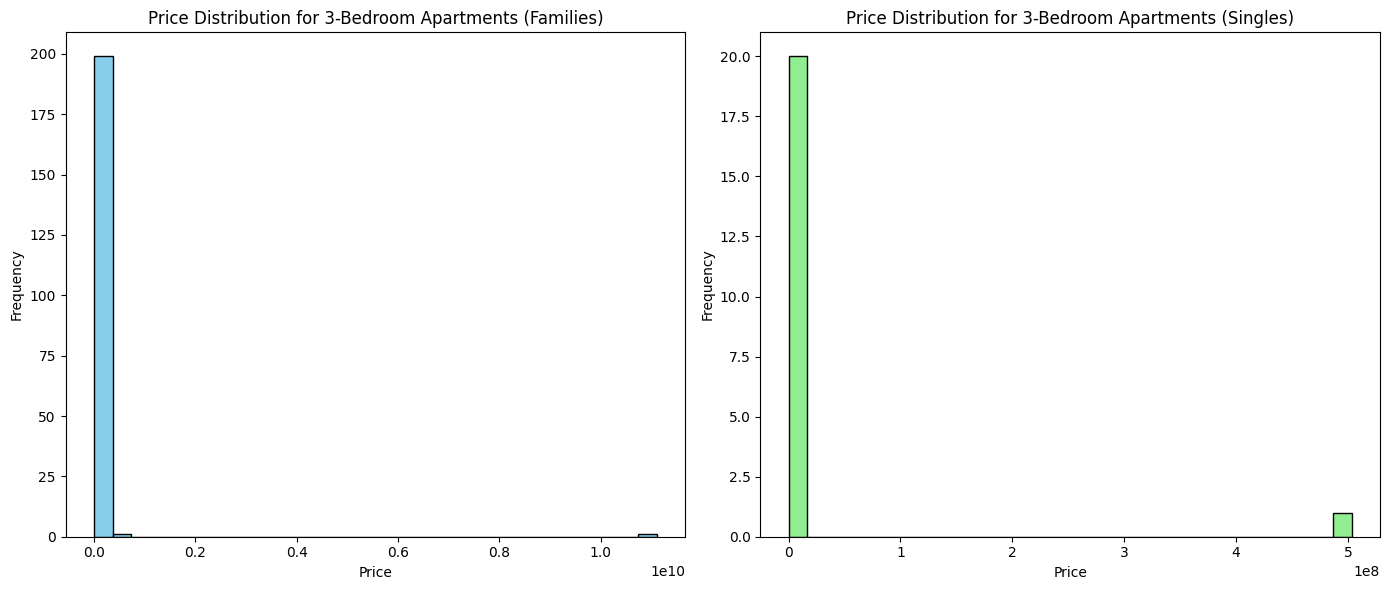

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Distribution of prices for 3-bedroom families apartments
ax[0].hist(three_bedroom_families['price'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Price Distribution for 3-Bedroom Apartments (Families)')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

# Distribution of prices for 3-bedroom singles apartments
ax[1].hist(three_bedroom_singles['price'], bins=30, color='lightgreen', edgecolor='black')
ax[1].set_title('Price Distribution for 3-Bedroom Apartments (Singles)')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Function to remove outliers

In [166]:
def remove_outliers(df, column_name):
    """
    Remove outliers from a dataframe based on the column specified.
    Outliers are defined as values more than 3 standard deviations from the mean.
    """
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    cutoff = std_dev * 3
    lower_bound = mean - cutoff
    upper_bound = mean + cutoff
    
    # Filter out the outliers
    cleaned_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return cleaned_df

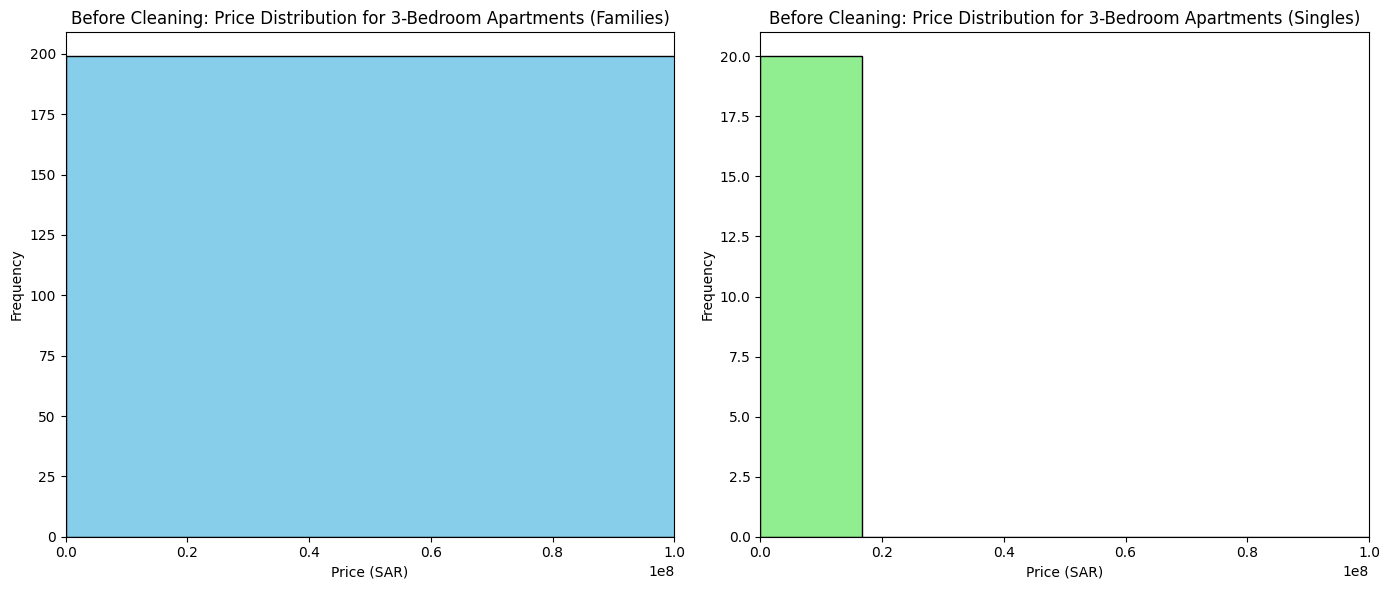

In [167]:
# Initial visualization of price distributions for 3-bedroom apartments
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 3-bedroom families apartments before cleaning
ax[0].hist(three_bedroom_families['price'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Before Cleaning: Price Distribution for 3-Bedroom Apartments (Families)')
ax[0].set_xlabel('Price (SAR)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([0, 100000000])  # Adjust based on your data to improve readability

# 3-bedroom singles apartments before cleaning
ax[1].hist(three_bedroom_singles['price'], bins=30, color='lightgreen', edgecolor='black')
ax[1].set_title('Before Cleaning: Price Distribution for 3-Bedroom Apartments (Singles)')
ax[1].set_xlabel('Price (SAR)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim([0, 100000000])  # Adjust based on your data to improve readability

plt.tight_layout()
plt.show()




Before Cleaning (Families and Singles): These histograms show the original price distributions for 3-bedroom apartments, catering to families and singles. The wide range of prices, especially with some extremely high values, indicates the presence of outliers that could significantly affect the average price calculations.


##### Remove outliers from the 3-bedroom datasets


In [168]:
three_bedroom_families_cleaned = remove_outliers(three_bedroom_families, 'price')
three_bedroom_singles_cleaned = remove_outliers(three_bedroom_singles, 'price')

##### Visualization of price distributions after removing outliers

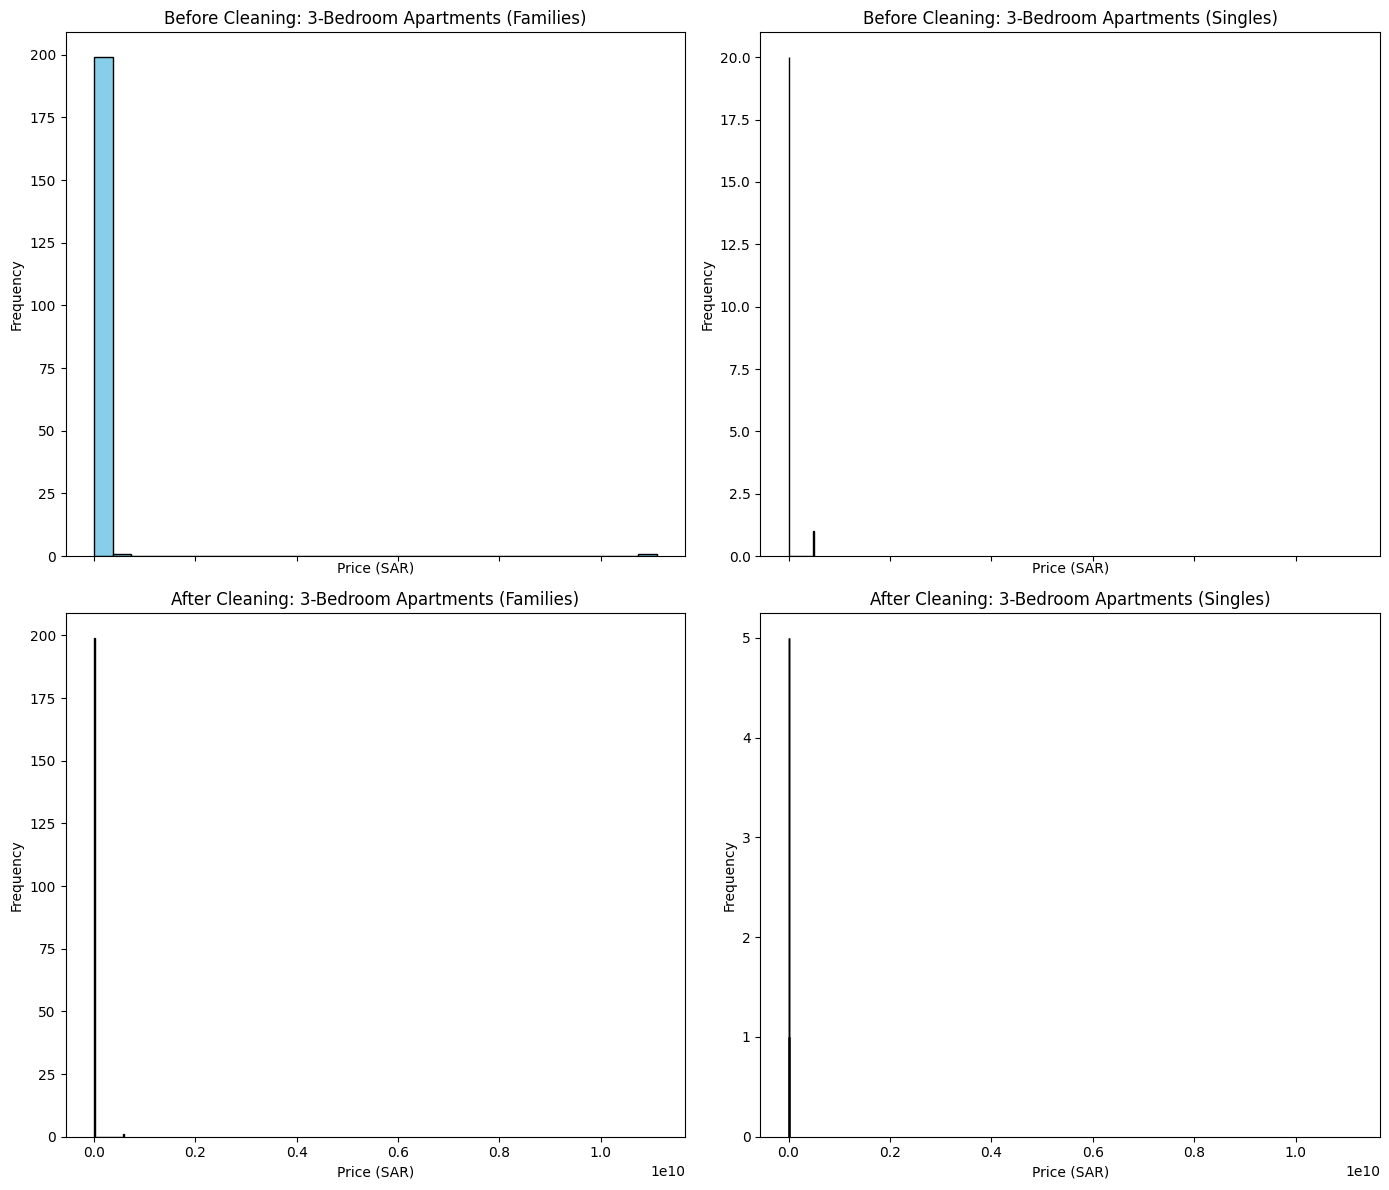

In [169]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12), sharex=True)

# Before cleaning - families
ax[0, 0].hist(three_bedroom_families['price'], bins=30, color='skyblue', edgecolor='black')
ax[0, 0].set_title('Before Cleaning: 3-Bedroom Apartments (Families)')
ax[0, 0].set_xlabel('Price (SAR)')
ax[0, 0].set_ylabel('Frequency')

# After cleaning - families
ax[1, 0].hist(three_bedroom_families_cleaned['price'], bins=30, color='skyblue', edgecolor='black')
ax[1, 0].set_title('After Cleaning: 3-Bedroom Apartments (Families)')
ax[1, 0].set_xlabel('Price (SAR)')
ax[1, 0].set_ylabel('Frequency')

# Before cleaning - singles
ax[0, 1].hist(three_bedroom_singles['price'], bins=30, color='lightgreen', edgecolor='black')
ax[0, 1].set_title('Before Cleaning: 3-Bedroom Apartments (Singles)')
ax[0, 1].set_xlabel('Price (SAR)')
ax[0, 1].set_ylabel('Frequency')

# After cleaning - singles
ax[1, 1].hist(three_bedroom_singles_cleaned['price'], bins=30, color='lightgreen', edgecolor='black')
ax[1, 1].set_title('After Cleaning: 3-Bedroom Apartments (Singles)')
ax[1, 1].set_xlabel('Price (SAR)')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


After Cleaning (Families and Singles): After removing outliers (defined as prices more than 3 standard deviations from the mean), these histograms present the cleaned price distributions. The distributions are now more concentrated, indicating a removal of extreme values. This cleaning process should lead to more representative average price calculations.


##### Recalculate the average prices without outliers

In [170]:
avg_price_three_bedroom_families_cleaned = three_bedroom_families_cleaned['price'].mean()
avg_price_three_bedroom_singles_cleaned = three_bedroom_singles_cleaned['price'].mean()

print(f"Average price for a 3-bedroom apartment for families (cleaned): {avg_price_three_bedroom_families_cleaned:.2f} SAR")
print(f"Average price for a 3-bedroom apartment for singles (cleaned): {avg_price_three_bedroom_singles_cleaned:.2f} SAR")


Average price for a 3-bedroom apartment for families (cleaned): 2986318.75 SAR
Average price for a 3-bedroom apartment for singles (cleaned): 5840.00 SAR


In [171]:
# Recalculate the average prices without outliers
rate_increase_families = ((avg_price_three_bedroom_families_cleaned - avg_price_two_bedroom_families) / avg_price_two_bedroom_families) * 100
rate_increase_singles = ((avg_price_three_bedroom_singles_cleaned - avg_price_two_bedroom_singles) / avg_price_two_bedroom_singles) * 100


In [172]:
rate_increase_families, rate_increase_singles

(2384.36279296875, -55.102646350860596)

These rates suggest a substantial increase in rent prices for families 
when moving from a 2-bedroom to a 3-bedroom apartment, while indicating a decrease for singles.
However, the negative rate for singles seems counterintuitive since 
it implies that moving to a larger apartment would, on average, cost less,
which is generally not expected in real estate markets.



## =================================================================================================================================================

## 2.Calculate the average duration it takes to close a post and mention the parameters that affect this duration. Also, mention the district with the shortest duration it takes to close a post with property type of villa.

### =================================================================================================================================================

I will consider the difference between updated and created date without checking is_closed it the duration to close the post 

##### Step 1: Calculate Duration to Close a Post


In [115]:
ad_table['created_at'] = pd.to_datetime(ad_table['created_at'])
ad_table['updated_at'] = pd.to_datetime(ad_table['updated_at'])
ad_table['closing_duration'] = (ad_table['updated_at'] - ad_table['created_at']).dt.days

##### Step 2: Identify Parameters Affecting Duration

In [114]:
ad_table.columns

Index(['id', 'district_id', 'property_type_id', 'district_name_en',
       'property_type', 'property_age_less_than', 'number_of_apartments',
       'number_of_bedrooms', 'floor', 'number_of_kitchens', 'is_closed',
       'residential_or_commercial', 'driver_room', 'is_duplex',
       'families_or_singles', 'is_furnished', 'halls_Num', 'maid_room',
       'price_per_meter', 'advertiser_type', 'has_swimming_pool', 'is_paid',
       'price', 'purpose', 'rent_type', 'rooms_num', 'space',
       'street_direction', 'street_width_range', 'toilets_num', 'latitude',
       'longitude', 'property_age_range', 'created_at', 'updated_at',
       'data_source', 'closing_duration'],
      dtype='object')

In [127]:
# This step involves statistical analysis. As a simple approach, you can start by examining correlations:
correlations = ad_table[['closing_duration','price', 'number_of_bedrooms', 'is_furnished', 'has_swimming_pool', 'maid_room','driver_room']].corr()
correlations

,closing_duration,price,number_of_bedrooms,is_furnished,has_swimming_pool,maid_room,driver_room
closing_duration,1.000000,-0.004561,-0.049748,-0.013467,0.046696,0.062801,0.068518
price,-0.004561,1.000000,-0.004130,0.007733,-0.000483,-0.004159,-0.003818
number_of_bedrooms,-0.049748,-0.004130,1.000000,0.099894,0.221229,0.534709,0.490236
is_furnished,-0.013467,0.007733,0.099894,1.000000,0.117984,0.114554,0.097253
has_swimming_pool,0.046696,-0.000483,0.221229,0.117984,1.000000,0.334912,0.352679
maid_room,0.062801,-0.004159,0.534709,0.114554,0.334912,1.000000,0.788474
driver_room,0.068518,-0.003818,0.490236,0.097253,0.352679,0.788474,1.000000


##### Step 3: Find the District with the Shortest Duration for Villas

###### Step 3.a identify villas from property_type_table

In [128]:
#property_type_table["property_type"].unique

In [129]:
villa_type_ids = property_type_table[(property_type_table['property_type'].str.lower() == 'villa')|(property_type_table['property_type'].str.lower() == 'فيلا')]['property_type_id']

###### Step 3.b Group by district_id and calculate average closing_duration

In [130]:
villa_ads = ad_table[ad_table['property_type_id'].isin(villa_type_ids)]
avg_duration_by_district = villa_ads.groupby('district_id')['closing_duration'].mean().reset_index()

###### Step 3.c Find the district with the shortest duration

In [131]:
shortest_duration_district = avg_duration_by_district.loc[avg_duration_by_district['closing_duration'].idxmin()]

###### Step 3.e Get district details

In [132]:
district_details = district_table[district_table['district_id'] == shortest_duration_district['district_id']]

###### Output

In [133]:
average_duration = ad_table['closing_duration'].mean()
print(f"Average closing duration: {average_duration} days")
print("Correlation with other parameters:\n", correlations)
print(f"District with shortest closing duration for villas: {district_details.iloc[0]['district_name_en']} (ID: {shortest_duration_district['district_id']})")


Average closing duration: 50.11803646396776 days
Correlation with other parameters:
                     closing_duration     price  number_of_bedrooms  \
closing_duration            1.000000 -0.004561           -0.049748   
price                      -0.004561  1.000000           -0.004130   
number_of_bedrooms         -0.049748 -0.004130            1.000000   
is_furnished               -0.013467  0.007733            0.099894   
has_swimming_pool           0.046696 -0.000483            0.221229   
maid_room                   0.062801 -0.004159            0.534709   
driver_room                 0.068518 -0.003818            0.490236   

                    is_furnished  has_swimming_pool  maid_room  driver_room  
closing_duration       -0.013467           0.046696   0.062801     0.068518  
price                   0.007733          -0.000483  -0.004159    -0.003818  
number_of_bedrooms      0.099894           0.221229   0.534709     0.490236  
is_furnished            1.000000          

### =================================================================================================================================================

## 3.Provide the correlation matrix for the effects on prices after normalization for both rents and sales, and comment on the most price affecting parameters.

### =================================================================================================================================================

In [134]:
ad_table.columns

Index(['id', 'district_id', 'property_type_id', 'district_name_en',
       'property_type', 'property_age_less_than', 'number_of_apartments',
       'number_of_bedrooms', 'floor', 'number_of_kitchens', 'is_closed',
       'residential_or_commercial', 'driver_room', 'is_duplex',
       'families_or_singles', 'is_furnished', 'halls_Num', 'maid_room',
       'price_per_meter', 'advertiser_type', 'has_swimming_pool', 'is_paid',
       'price', 'purpose', 'rent_type', 'rooms_num', 'space',
       'street_direction', 'street_width_range', 'toilets_num', 'latitude',
       'longitude', 'property_age_range', 'created_at', 'updated_at',
       'data_source', 'closing_duration'],
      dtype='object')

In [136]:
# Assuming 'ad_table' contains your data, including both rent and sale prices in a 'price' column
# and a 'for_sale_or_rent' column to differentiate between sale (e.g., value 0) and rent (e.g., value 1)

# Step 1: Normalize the price data
scaler = MinMaxScaler()
ad_table['normalized_price'] = scaler.fit_transform(ad_table[['price']])

# Step 2: Select relevant parameters (assuming these columns exist in your dataframe)
parameters = ['number_of_bedrooms', 'space', 'toilets_num', 'property_age_range', 'normalized_price','has_swimming_pool','maid_room','driver_room']

# Step 3: Calculate the correlation matrix
correlation_matrix = ad_table[parameters].corr()

# Display the correlation matrix
print(correlation_matrix)

                    number_of_bedrooms     space  normalized_price  \
number_of_bedrooms            1.000000 -0.011265         -0.004130   
space                        -0.011265  1.000000          0.207093   
normalized_price             -0.004130  0.207093          1.000000   
has_swimming_pool             0.221229  0.012604         -0.000483   
maid_room                     0.534709 -0.003503         -0.004159   
driver_room                   0.490236 -0.002513         -0.003818   

                    has_swimming_pool  maid_room  driver_room  
number_of_bedrooms           0.221229   0.534709     0.490236  
space                        0.012604  -0.003503    -0.002513  
normalized_price            -0.000483  -0.004159    -0.003818  
has_swimming_pool            1.000000   0.334912     0.352679  
maid_room                    0.334912   1.000000     0.788474  
driver_room                  0.352679   0.788474     1.000000  


### =================================================================================================================================================

## 4.Give a sales price valuation of rental properties (convert rental properties to sales properties) based on 6% ROI (Return on Investment) then estimate the meter price distribution per property type and district and comment on the result.

### =================================================================================================================================================

RENT_TYPE :->
Yearly = 0, 
Daily = 1,
Monthly = 2

PURPOSE :->
SALE = 0
RENT = 1

###### 1. Filter for rental properties (purpose = 1 for rent)

In [138]:
rentals = ad_table[ad_table['purpose'] == 1]

###### 2. Convert rental price to annual basis
Daily to yearly: Multiply by 365
Monthly to yearly: Multiply by 12
Yearly remains the same

In [139]:
rentals['annual_rent'] = rentals.apply(
    lambda x: x['price'] * 365 if x['rent_type'] == 1 else (x['price'] * 12 if x['rent_type'] == 2 else x['price']),
    axis=1
)

/var/folders/fw/2jnclknn08g378bkr2zksm5h0000gn/T/ipykernel_10323/3254155969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['annual_rent'] = rentals.apply(


###### 3. Calculate sales price valuation based on 6% ROI

In [140]:
rentals['sales_price_valuation'] = rentals['annual_rent'] / 0.06

/var/folders/fw/2jnclknn08g378bkr2zksm5h0000gn/T/ipykernel_10323/2013283491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['sales_price_valuation'] = rentals['annual_rent'] / 0.06


###### 4. Calculate price per meter

In [141]:
rentals['price_per_meter'] = rentals['sales_price_valuation'] / rentals['space']


/var/folders/fw/2jnclknn08g378bkr2zksm5h0000gn/T/ipykernel_10323/2672916109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentals['price_per_meter'] = rentals['sales_price_valuation'] / rentals['space']


###### 5. Group by property type and district, and calculate descriptive statistics for price per meter

In [142]:
grouped_data = rentals.groupby(['property_type', 'district_name_en'])['price_per_meter'].describe()


/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4012: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)
/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4012: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)
/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/Users/mohammadshbaita/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:4012: RuntimeWarning: invalid value encounter

In [ ]:
print(grouped_data.head(100))


In [145]:

# Assuming 'grouped_data' is the DataFrame you want to clean
cleaned_grouped_data = grouped_data.dropna()
print(cleaned_grouped_data.head(100))


                                count          mean           std  \
property_type district_name_en                                      
أرض           Ad Dar Al Baida     2.0  2.644231e+03  7.932288e+02   
              Al Aqiq             5.0  5.134377e+03  3.281292e+03   
              Al Faiha            2.0  1.482143e+03  1.271109e+03   
              Al Faisaliyah       4.0  3.165412e+03  2.125569e+03   
              Al Ghnamiah         5.0  1.960140e+03  2.005449e+03   
...                               ...           ...           ...   
استراحة       As Sulai           31.0  1.105599e+04  3.538762e+04   
              Ash Sharq          88.0  1.415873e+04  8.636449e+04   
              Ash Shifa           5.0  3.457204e+04  6.481482e+04   
              Badr               13.0  4.058979e+03  7.243406e+03   
              Banban             29.0  5.993984e+07  3.227551e+08   

                                        min          25%          50%  \
property_type district_name_e

In [146]:
cleaned_grouped_data.to_csv("cleaned_grouped_data.csv")

###### Highest and Lowest Average Price per Meter

In [148]:
highest_avg = cleaned_grouped_data.sort_values(by='mean', ascending=False).head(5)
lowest_avg = cleaned_grouped_data.sort_values(by='mean', ascending=True).head(5)



###### Highest and Lowest Standard Deviation

In [149]:
highest_std = cleaned_grouped_data.sort_values(by='std', ascending=False).head(5)
lowest_std = cleaned_grouped_data.sort_values(by='std', ascending=True).head(5)

###### Potential Outliers based on Max and Min Values

In [151]:
potential_outliers_max = cleaned_grouped_data.sort_values(by='max', ascending=False).head(5)
potential_outliers_min = cleaned_grouped_data.sort_values(by='min', ascending=True).head(5)

In [152]:
print("Highest Average Price per Meter:")
print(highest_avg)

Highest Average Price per Meter:
                                   count          mean           std  \
property_type district_name_en                                         
استراحة       Dhahrat Namar         23.0  2.938877e+09  1.409401e+10   
              Al Maizilah           25.0  3.753019e+08  1.875861e+09   
محل           Al Amal                2.0  8.516669e+07  1.204438e+08   
              An Nasim Ash Sharqi   23.0  8.238752e+07  3.949045e+08   
              Laban                 13.0  7.147974e+07  2.567302e+08   

                                           min           25%           50%  \
property_type district_name_en                                               
استراحة       Dhahrat Namar        1481.481481  4.416667e+03  9.125000e+03   
              Al Maizilah             0.888889  2.756892e+03  4.245283e+03   
محل           Al Amal                41.025641  4.258336e+07  8.516669e+07   
              An Nasim Ash Sharqi    67.500068  7.256944e+03  1.041667e+

In [153]:
print("\nLowest Average Price per Meter:")
print(lowest_avg)



Lowest Average Price per Meter:
                                  count        mean         std        min  \
property_type district_name_en                                               
بيت           Qurtubah              2.0    9.333051   10.370500   2.000000   
أرض           Al Muhammadiyah       2.0   84.258333  116.542983   1.850000   
مستودع        Hyt                   2.0   86.937500  117.939519   3.541667   
استراحة       Al Uraija Al Wusta    2.0   91.666667  106.066017  16.666667   
              Al Haer               2.0  101.273148   77.749010  46.296296   

                                        25%         50%         75%  \
property_type district_name_en                                        
بيت           Qurtubah             5.666526    9.333051   12.999577   
أرض           Al Muhammadiyah     43.054167   84.258333  125.462500   
مستودع        Hyt                 45.239583   86.937500  128.635417   
استراحة       Al Uraija Al Wusta  54.166667   91.666667  129.1666

In [154]:
print("\nHighest Standard Deviation in Price per Meter:")
print(highest_std)



Highest Standard Deviation in Price per Meter:
                                   count          mean           std  \
property_type district_name_en                                         
استراحة       Dhahrat Namar         23.0  2.938877e+09  1.409401e+10   
              Al Maizilah           25.0  3.753019e+08  1.875861e+09   
محل           An Nasim Ash Sharqi   23.0  8.238752e+07  3.949045e+08   
استراحة       Banban                29.0  5.993984e+07  3.227551e+08   
محل           Laban                 13.0  7.147974e+07  2.567302e+08   

                                           min          25%           50%  \
property_type district_name_en                                              
استراحة       Dhahrat Namar        1481.481481  4416.666667   9125.000000   
              Al Maizilah             0.888889  2756.892231   4245.283019   
محل           An Nasim Ash Sharqi    67.500068  7256.944444  10416.666667   
استراحة       Banban                 92.592593  1703.333333   

In [156]:
print("\nLowest Standard Deviation in Price per Meter:")
print(lowest_std)



Lowest Standard Deviation in Price per Meter:
                                count          mean  std           min  \
property_type district_name_en                                           
محل           Al Mikal            2.0  15277.777778  0.0  15277.777778   
استراحة       Al Faiha            4.0  16222.222222  0.0  16222.222222   
مستودع        Al Yarmuk           2.0   5333.333333  0.0   5333.333333   
مكتب تجاري    An Nazim            3.0   5000.000000  0.0   5000.000000   
بيت           Jarir               2.0   4772.727273  0.0   4772.727273   

                                         25%           50%           75%  \
property_type district_name_en                                             
محل           Al Mikal          15277.777778  15277.777778  15277.777778   
استراحة       Al Faiha          16222.222222  16222.222222  16222.222222   
مستودع        Al Yarmuk          5333.333333   5333.333333   5333.333333   
مكتب تجاري    An Nazim           5000.000000   5000.00

In [157]:
print("\nPotential Outliers with Highest Max Value:")
print(potential_outliers_max)


Potential Outliers with Highest Max Value:
                                   count          mean           std  \
property_type district_name_en                                         
استراحة       Dhahrat Namar         23.0  2.938877e+09  1.409401e+10   
              Al Maizilah           25.0  3.753019e+08  1.875861e+09   
محل           An Nasim Ash Sharqi   23.0  8.238752e+07  3.949045e+08   
استراحة       Banban                29.0  5.993984e+07  3.227551e+08   
محل           Laban                 13.0  7.147974e+07  2.567302e+08   

                                           min          25%           50%  \
property_type district_name_en                                              
استراحة       Dhahrat Namar        1481.481481  4416.666667   9125.000000   
              Al Maizilah             0.888889  2756.892231   4245.283019   
محل           An Nasim Ash Sharqi    67.500068  7256.944444  10416.666667   
استراحة       Banban                 92.592593  1703.333333   2380

In [158]:
print("\nProperties with Lowest Min Value indicating potential outliers or data issues:")
print(potential_outliers_min)



Properties with Lowest Min Value indicating potential outliers or data issues:
                                  count          mean           std       min  \
property_type district_name_en                                                  
عمارة         Al Uraija             5.0  2.086621e+04  2.688352e+04  0.000000   
أرض           An Nasim Al Gharbi   35.0  2.697102e+06  1.066860e+07  0.000014   
استراحة       An Nasim Al Gharbi   47.0  4.487947e+04  1.397048e+05  0.000450   
فيلا          King Abdul Aziz      32.0  7.114926e+03  1.439826e+04  0.001667   
أرض           Ishbiliyah            9.0  4.258184e+03  2.869291e+03  0.004167   

                                          25%           50%           75%  \
property_type district_name_en                                              
عمارة         Al Uraija           5442.176871  10000.000000  22222.222222   
أرض           An Nasim Al Gharbi   291.666720   2272.727273   5773.907104   
استراحة       An Nasim Al Gharbi  1644.44444

### =================================================================================================================================================

## 5.Add any general insights you find during your work on the data

### =================================================================================================================================================

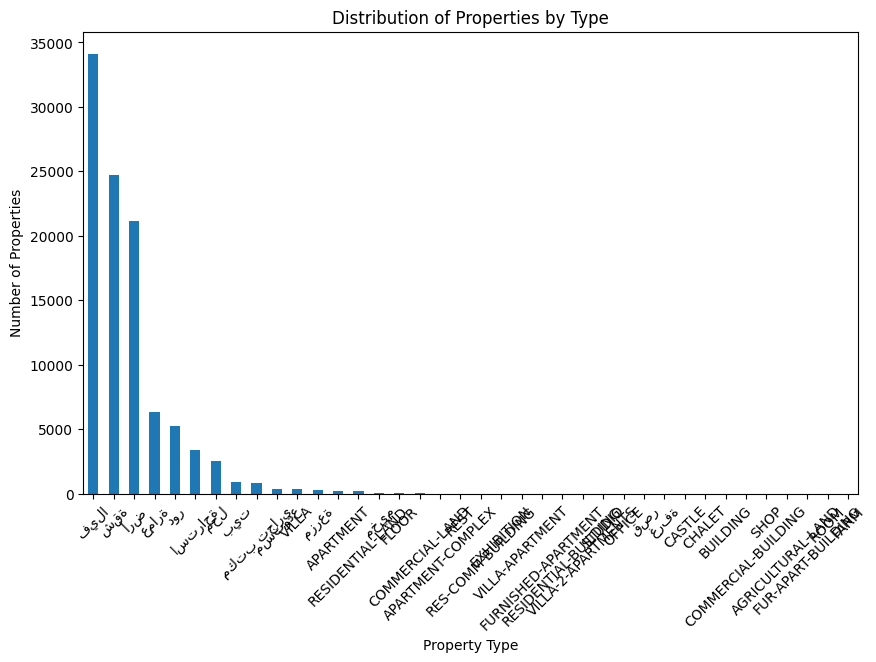

فيلا                    34123
شقة                     24675
أرض                     21142
عمارة                    6329
دور                      5250
استراحة                  3397
محل                      2555
بيت                       917
مكتب تجاري                820
مستودع                    383
VILLA                     327
مزرعة                     289
APARTMENT                 175
RESIDENTIAL-LAND          173
مخيم                       73
FLOOR                      53
COMMERCIAL-LAND            27
APARTMENT-COMPLEX           6
REST                        6
RES-COMM-BUILDING           6
EXHIBITION                  4
VILLA-APARTMENT             3
FURNISHED-APARTMENT         3
RESIDENTIAL-BUILDING        2
VILLA-2-APARTMENTS          2
STUDIO                      2
OFFICE                      2
قصر                         2
غرفة                        2
CASTLE                      1
CHALET                      1
BUILDING                    1
COMMERCIAL-BUILDING         1
SHOP      

In [161]:
# Distribution of Properties by Type
property_type_distribution = ad_table['property_type'].value_counts()

# Plotting the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
property_type_distribution.plot(kind='bar')
plt.title('Distribution of Properties by Type')
plt.xlabel('Property Type')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()

# Output the distribution
print(property_type_distribution)


### Recommendations for Further Analysis:

1- Standardization of Property Types: Combining the counts of similarly named property types listed in both English and Arabic (e.g., VILLA and فيلا) could provide a more accurate distribution and understanding of the market.

2- In-depth Analysis of Niche Properties: Exploring the characteristics and pricing of less common or unique properties might uncover specific market trends or investment opportunities.

3- Market Segmentation: Further analysis could segment the market based on property types, identifying trends, demands, and pricing within each segment.
